# Certificate in Data Science | Assignment 5 |  
> University of Washington, Seattle, WA    
> December 2019  
> N. Hicks

## Problem Statement

Rooney's client is a tech-manufacturing startup working on a number of automated detection devices for the medical and construction industries. Among the auto-detection devices is a reader that looks at possible carcinoma tissue samples to classify the sample as either benign or malignant. Rooney asks you for help in developing a better algorithm than the current classifier, perhaps a decision tree can help.

For this assignment, you will be designing an experiment using decision tree classifiers for the detection of breast cancer and comparing the accuracy.

REF: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)

## Assignment Instructions

Using the WI_Breast_Cancer csv file, create a new notebook to build a decision tree classifier that would be able to detect whether a tumor is benign or malignant. Complete the following tasks and answer the questions:

- Test both entropy and the gini coefficient. Which performs better and why?
- What are the best hyperparameter settings for both?
- Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?
- Determine the AUC for the best model you can achieve. What are the precision and recal values and which might be the one you want to maximize?
- What are the implications of using this type of machine learning algorithm for breast cancer analysis?


## Import Libraries

In [1]:
'''
Import Required Libraries
'''
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
import os

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from subprocess import check_call
from IPython.display import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

C:\Users\NateDogg\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\NateDogg\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\NateDogg\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be r

## Establish the Datatset

### Functions for Scripting

In [2]:
'''
Retrieve the prescribed dataset.
RETURN: pd.DataFrame
'''
def fetch_data(path, file):
    try:
        # import the file to a dataframe
        _df = pd.read_csv(path + file, sep=' ', header=None)
        print('REMOTE FILE USED')
    except:
        # Local Copy -- Link would not permit access
        path = os.getcwd()
        print('LOCAL FILE USED')
        # import the file to a dataframe
        _df = pd.read_csv(os.path.join(path, file), sep=',', header=None)
    
    return _df

In [3]:
'''
Tools for viewing a dataset
INPUT: pd.DataFrame
OUTPUT: print the results
'''
def print_data_attrs(_df):
    print(_df.info())          # gives the structure of the data (rows/cols)
    print('\nDATASET HEAD\n{}'.format(_df.head()))          # shows the top five data entries
    print('\nDATASET DESCRIBE\n{}'.format(_df.describe()))      # gives the statistics on the data in the DF

In [4]:
'''
Describe all unique attributes of all dataset features
INPUT: pd.DataFrame
RETURN: pd.Series; print unique values
'''
def get_unique_vals(_df):
    features_all = _df.columns
    print('THE UNIQUE VALUES OF ALL DATASET FEATURES')
    print('=========================================')
    for feature in features_all:
        val = _df[feature].unique()
        print('\n' + str(feature) + ' ({}):\n{}'.format(len(val), val))

In [5]:
'''
Convert and update a feature column to numeric dtype
INPUT: _df|a DataFrame, attributes|as a list of column names
RETURN: pd.DataFrame
'''
def convert_attribute_to_numeric(_df, attributes):
    print('OBJECT COLUMNS CONVERTED TO NUMERIC DTYPES')
    print('==========================================')
    for attr in attributes:
        val = _df[attr].dtype
        if  val == 'object':
            print('({}) {}'.format(attr, _df[attr].dtype))
            _df[attr] = pd.to_numeric(_df[attr])
    
    return _df

In [6]:
'''
Generate an accuracy Score.
INPUT: y_test|the test target, y_pred|the predicted scores.
RETURN: prints the Accuracy Score.
'''
def print_scores(y_test, y_pred):
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred)*100))

In [7]:
'''
Establish an appropriately labeled confusion matrix  
INPUT: y_test|test target, y_pred| test prediction, pos|positivie outcome, neg|negative outcome
RETURN: pd.DataFrame
'''
def conf_matrix(y_test, y_pred, pos, neg):
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns=['Predicted '+neg, 'Predicted '+pos],
        index=['True '+neg, 'True '+pos]
    )

In [8]:
'''
Create a visualization of a decision tree -- must install graphviz and pydot2 packages for this to work
INPUT: model|the decision tree model, labels|the column labels as type 'list'
RETURNS: image file of the decision tree
'''
def tree_visualize(model, labels, file_out):
    dotfile = open(file_out + '.dot', 'w')
    tree.export_graphviz(model, out_file=dotfile, feature_names=labels)
    dotfile.close()

    # Convert the dot file to a png -- optional method
    #import os
#     os.system("dot -Tpng dtree.dot -o dtree.png")

    # Convert the dot file to a png
    check_call(['dot','-Tpng', file_out + '.dot', '-o', file_out + '.png'])

In [9]:
'''
Derive the hyperparameter results of a decision tree via looping the given parameters
RETURN: output the model accuracies
'''
def tune_tree(print_label, leaf=None, depth=None, leaf2=1, split=2):
    print('====================')
    print('ENTROPY COEFFICIENTS - {}'.format(print_label))
    print('====================')
    model_ent = DecisionTreeClassifier(criterion='entropy',
                                       splitter='best',
                                       max_depth=depth,
                                       min_samples_split=split,
                                       max_leaf_nodes=leaf,
                                       min_samples_leaf=leaf2
                                       ).fit(X_train, y_train) 
    y_ent_pred = model_ent.predict(X_test)
    print_scores(y_test, y_ent_pred)

    print('=================')
    print('GINI COEFFICIENTS -    {}'.format(print_label))
    print('=================')
    model_gini = DecisionTreeClassifier(criterion='gini',
                                        splitter='best',
                                        max_depth=depth,
                                        min_samples_split=split,
                                        max_leaf_nodes=leaf,
                                        min_samples_leaf=leaf2
                                        ).fit(X_train, y_train) 
    y_gini_pred = model_gini.predict(X_test)
    print_scores(y_test, y_gini_pred)
    print('\n')

### Import the Data

In [10]:
# import the sensors dataset
path = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/'   # check this repository first; else use current working directory
file = 'WI_Breast_Cancer.csv'
cancer_df = fetch_data(path, file)

LOCAL FILE USED


### Wrangle the Data

In [11]:
# return the basic dataset perspectives
print_data_attrs(cancer_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 11 columns):
0     709 non-null object
1     702 non-null object
2     702 non-null float64
3     701 non-null float64
4     701 non-null float64
5     701 non-null float64
6     701 non-null float64
7     701 non-null float64
8     701 non-null float64
9     701 non-null float64
10    701 non-null object
dtypes: float64(8), object(3)
memory usage: 61.1+ KB
None

DATASET HEAD
        0  1    2    3    4    5    6     7    8    9  10
0  1000025  2  5.0  1.0  1.0  1.0  2.0   1.0  3.0  1.0  1
1  1002945  2  5.0  4.0  4.0  5.0  7.0  10.0  3.0  2.0  1
2  1015425  2  3.0  1.0  1.0  1.0  2.0   2.0  3.0  1.0  1
3  1016277  2  6.0  8.0  8.0  1.0  3.0   4.0  3.0  7.0  1
4  1017023  2  4.0  1.0  1.0  3.0  2.0   1.0  3.0  1.0  1

DATASET DESCRIBE
                 2           3          4           5           6           7  \
count   702.000000  701.000000  701.00000  701.000000  701.000000  701.000000   
m

In [12]:
# establish the unique values of all attributes individualy
get_unique_vals(cancer_df)

THE UNIQUE VALUES OF ALL DATASET FEATURES

0 (654):
['1000025' '1002945' '1015425' '1016277' '1017023' '1017122' '1018099'
 '1018561' '1033078' '1035283' '1036172' '1041801' '1043999' '1044572'
 '1047630' '1048672' '1049815' '1050670' '1050718' '1054590' '1054593'
 '1056784' '1057013' '1059552' '1065726' '1066373' '1066979' '1067444'
 '1070935' '1071760' '1072179' '1074610' '1075123' '1079304' '1080185'
 '1081791' '1084584' '1091262' '1096800' '1099510' '1100524' '1102573'
 '1103608' '1103722' '1105257' '1105524' '1106095' '1106829' '1108370'
 '1108449' '1110102' '1110503' '1110524' '1111249' '1112209' '1113038'
 '1113483' '1113906' '1115282' '1115293' '1116116' '1116132' '1116192'
 '1116998' '1117152' '1118039' '1120559' '1121732' '1121919' '1123061'
 '1124651' '1125035' '1126417' '1131294' '1132347' '1133041' '1133136'
 '1136142' '1137156' '1143978' '1147044' '1147699' '1147748' '1148278'
 '1148873' '1152331' '1155546' '1156272' '1156948' '1157734' '1158247'
 '1160476' '1164066' '116

In [13]:
# based upon the prior result above:
# Drop rows with 'NaN' elements.
cancer_df = cancer_df.dropna() 

In [14]:
# remove rows that contain the specified string
cancer_df = cancer_df[~cancer_df[0].str.contains('#####')]
cancer_df = cancer_df[~cancer_df[10].str.contains('<-----')]

In [15]:
# replace all '3 ' values with '3' values
cancer_df[10] = cancer_df[10].replace('3 ', '3')

# for the target attribute, replace '2|benign' with '0', and '4|malignant' with '1' 
cancer_df[1] = cancer_df[1].replace('2', '0')
cancer_df[1] = cancer_df[1].replace('4', '1')

In [16]:
# establish the unique values of all attributes individualy
get_unique_vals(cancer_df)

THE UNIQUE VALUES OF ALL DATASET FEATURES

0 (645):
['1000025' '1002945' '1015425' '1016277' '1017023' '1017122' '1018099'
 '1018561' '1033078' '1035283' '1036172' '1041801' '1043999' '1044572'
 '1047630' '1048672' '1049815' '1050670' '1050718' '1054590' '1054593'
 '1056784' '1057013' '1059552' '1065726' '1066373' '1066979' '1067444'
 '1070935' '1071760' '1072179' '1074610' '1075123' '1079304' '1080185'
 '1081791' '1084584' '1091262' '1096800' '1099510' '1100524' '1102573'
 '1103608' '1103722' '1105257' '1105524' '1106095' '1106829' '1108370'
 '1108449' '1110102' '1110503' '1110524' '1111249' '1112209' '1113038'
 '1113483' '1113906' '1115282' '1115293' '1116116' '1116132' '1116192'
 '1116998' '1117152' '1118039' '1120559' '1121732' '1121919' '1123061'
 '1124651' '1125035' '1126417' '1131294' '1132347' '1133041' '1133136'
 '1136142' '1137156' '1143978' '1147044' '1147699' '1147748' '1148278'
 '1148873' '1152331' '1155546' '1156272' '1156948' '1157734' '1158247'
 '1160476' '1164066' '116

In [17]:
# return the DataFrame column names, as a list
col_names = list(cancer_df)

In [18]:
# Convert the 'object' dtypes to 'int'
cancer_df = convert_attribute_to_numeric(cancer_df, col_names)
print('\n')
# return the basic dataset perspectives
print_data_attrs(cancer_df)

OBJECT COLUMNS CONVERTED TO NUMERIC DTYPES
(0) object
(1) object
(10) object


<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 708
Data columns (total 11 columns):
0     699 non-null int64
1     699 non-null int64
2     699 non-null float64
3     699 non-null float64
4     699 non-null float64
5     699 non-null float64
6     699 non-null float64
7     699 non-null float64
8     699 non-null float64
9     699 non-null float64
10    699 non-null int64
dtypes: float64(8), int64(3)
memory usage: 65.5 KB
None

DATASET HEAD
        0   1    2    3    4    5    6     7    8    9   10
0  1000025   0  5.0  1.0  1.0  1.0  2.0   1.0  3.0  1.0   1
1  1002945   0  5.0  4.0  4.0  5.0  7.0  10.0  3.0  2.0   1
2  1015425   0  3.0  1.0  1.0  1.0  2.0   2.0  3.0  1.0   1
3  1016277   0  6.0  8.0  8.0  1.0  3.0   4.0  3.0  7.0   1
4  1017023   0  4.0  1.0  1.0  3.0  2.0   1.0  3.0  1.0   1

DATASET DESCRIBE
                 0           1           2           3           4   \
count 

In [19]:
# give the attributes the specified names
cancer_df = cancer_df.rename(columns={0: 'Sample', 1: 'Class',
                                      2: 'Clump_Thickness', 3: 'Uniformity_Cell_Size',
                                      4: 'Uniformity_Cell_Shape', 5: 'Marginal_Adhesion',
                                      6: 'Epithelial_Cell_Size', 7: 'Bare_Nuclei',
                                      8: 'Bland_Chromatin', 9: 'Normal_Nucleoli',
                                      10: 'Mitosis'
                                     })

## Establish Decision Trees

In [20]:
# Establish the features and targets
X = cancer_df.copy()         # load features into X DF
X = X.drop(['Sample', 'Class'], axis=1)
Y = cancer_df.iloc[:, 1]     # Load target into Y DF
print(X.head())
print('\n{}'.format(Y.head()))

   Clump_Thickness  Uniformity_Cell_Size  Uniformity_Cell_Shape  \
0              5.0                   1.0                    1.0   
1              5.0                   4.0                    4.0   
2              3.0                   1.0                    1.0   
3              6.0                   8.0                    8.0   
4              4.0                   1.0                    1.0   

   Marginal_Adhesion  Epithelial_Cell_Size  Bare_Nuclei  Bland_Chromatin  \
0                1.0                   2.0          1.0              3.0   
1                5.0                   7.0         10.0              3.0   
2                1.0                   2.0          2.0              3.0   
3                1.0                   3.0          4.0              3.0   
4                3.0                   2.0          1.0              3.0   

   Normal_Nucleoli  Mitosis  
0              1.0        1  
1              2.0        1  
2              1.0        1  
3              7.0  

In [21]:
# return the count of the target attributes; assess dataset imbalance
temp_count = Y.value_counts()
print('Original dataset size (0: {}, 1: {})'.format(temp_count[0], temp_count[1]))

Original dataset size (0: 458, 1: 241)


In [22]:
# oversample the dataset to balance it, for improved tree results
sm_res = SMOTE(random_state=43)
X_sm, Y_sm = sm_res.fit_sample(X, Y)
print('Resampled dataset shape {}'.format(Counter(Y_sm)))

Resampled dataset shape Counter({0: 458, 1: 458})


In [23]:
# Ensure the decision tree is deterministic
np.random.seed(101)

# X_train, X_test, y_train, y_test = train_test_split(X_sm, Y_sm, test_size = 0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)

### Basic Decision Tree Accuracies

In [24]:
# return the basic entropy decision tree
model_ent = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)
y_ent_pred = model_ent.predict(X_test)
print_scores(y_test, y_ent_pred)

Accuracy: 93.57142857142857%


In [25]:
# return the basic gini decision tree
model_gini = DecisionTreeClassifier(criterion='gini').fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_test)
print_scores(y_test, y_gini_pred)

Accuracy: 90.0%


In [26]:
print(' CONFUSION MATRIX - ENTROPY MODEL')
conf_matrix(y_test, y_ent_pred, 'Malignant', 'Benign')

 CONFUSION MATRIX - ENTROPY MODEL


,Predicted Benign,Predicted Malignant
True Benign,91,1
True Malignant,8,40


In [27]:
print(' CONFUSION MATRIX - GINI MODEL')
conf_matrix(y_test, y_gini_pred, 'Malignant', 'Benign')

 CONFUSION MATRIX - GINI MODEL


,Predicted Benign,Predicted Malignant
True Benign,91,1
True Malignant,13,35


### Hyperparameter Tuning

In [28]:
# Use the entropy coefficient model

leaf_nodes = np.arange(2,10)
max_depth = np.arange(1,10)
min_leaf = np.arange(1,10)
min_split = np.arange(2,10)
all_vals = [leaf_nodes, max_depth, min_leaf, min_split]

i = 0
for single_val in all_vals:
    print('-------')
    
    for j in single_val:
        if i == 0:
            label = 'MAX LEAF NODES: '
            leaf = j
        elif i == 1:
            label = 'MAX TREE DEPTH: '
            depth = j
        elif i == 2:
            label = 'MAX SAMPLES LEAF: '
            leaf2 = j
        elif i == 3:
            label = 'MAX SAMPLES SPLIT: '
            split = j
        label = label + str(j)
        tune_tree(label, leaf=None, depth=None, leaf2=1, split=2)
    
    i += 1

-------
ENTROPY COEFFICIENTS - MAX LEAF NODES: 2
Accuracy: 93.57142857142857%
GINI COEFFICIENTS -    MAX LEAF NODES: 2
Accuracy: 91.42857142857143%


ENTROPY COEFFICIENTS - MAX LEAF NODES: 3
Accuracy: 93.57142857142857%
GINI COEFFICIENTS -    MAX LEAF NODES: 3
Accuracy: 92.14285714285714%


ENTROPY COEFFICIENTS - MAX LEAF NODES: 4
Accuracy: 92.85714285714286%
GINI COEFFICIENTS -    MAX LEAF NODES: 4
Accuracy: 91.42857142857143%


ENTROPY COEFFICIENTS - MAX LEAF NODES: 5
Accuracy: 93.57142857142857%
GINI COEFFICIENTS -    MAX LEAF NODES: 5
Accuracy: 91.42857142857143%


ENTROPY COEFFICIENTS - MAX LEAF NODES: 6
Accuracy: 93.57142857142857%
GINI COEFFICIENTS -    MAX LEAF NODES: 6
Accuracy: 90.0%


ENTROPY COEFFICIENTS - MAX LEAF NODES: 7
Accuracy: 93.57142857142857%
GINI COEFFICIENTS -    MAX LEAF NODES: 7
Accuracy: 91.42857142857143%


ENTROPY COEFFICIENTS - MAX LEAF NODES: 8
Accuracy: 92.85714285714286%
GINI COEFFICIENTS -    MAX LEAF NODES: 8
Accuracy: 90.71428571428571%


ENTROPY COE

### Visualize the Decision Trees

In [29]:
# define the updated hyperparameters    
leaf = None
depth = 5
leaf2 = 2
split = 3

In [30]:
# refine the ENTROPY model with updated hyperparameters
model_ent = DecisionTreeClassifier(criterion='entropy',
                                   splitter='best',
                                   max_depth=depth,
                                   min_samples_split=split,
                                   max_leaf_nodes=leaf,
                                   min_samples_leaf=leaf2
                                   ).fit(X_train, y_train) 
y_ent_pred = model_ent.predict(X_test)
print_scores(y_test, y_ent_pred)

Accuracy: 93.57142857142857%


In [31]:
# refine the GINI model with updated hyperparameters
model_gini = DecisionTreeClassifier(criterion='gini',
                                    splitter='best',
                                    max_depth=depth,
                                    min_samples_split=split,
                                    max_leaf_nodes=leaf,
                                    min_samples_leaf=leaf2
                                    ).fit(X_train, y_train) 
y_gini_pred = model_gini.predict(X_test)
print_scores(y_test, y_gini_pred)

Accuracy: 93.57142857142857%


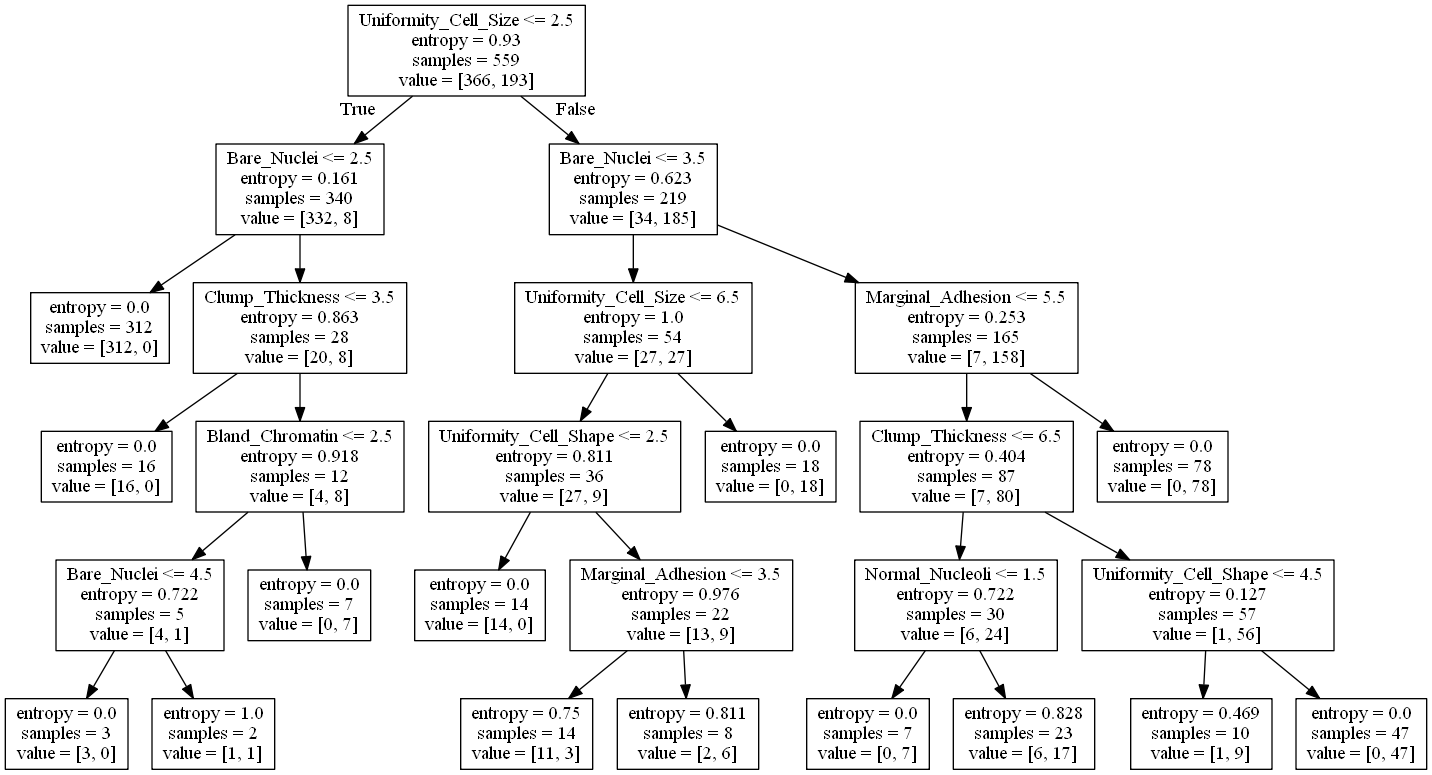

In [32]:
# return the DataFrame column names, as a list
col_names = list(X)
# establish the PNG image file type of the decision tree results
file_out = 'model_ent'
tree_visualize(model_ent, col_names, file_out)
# display the image
Image(filename=file_out + '.png')

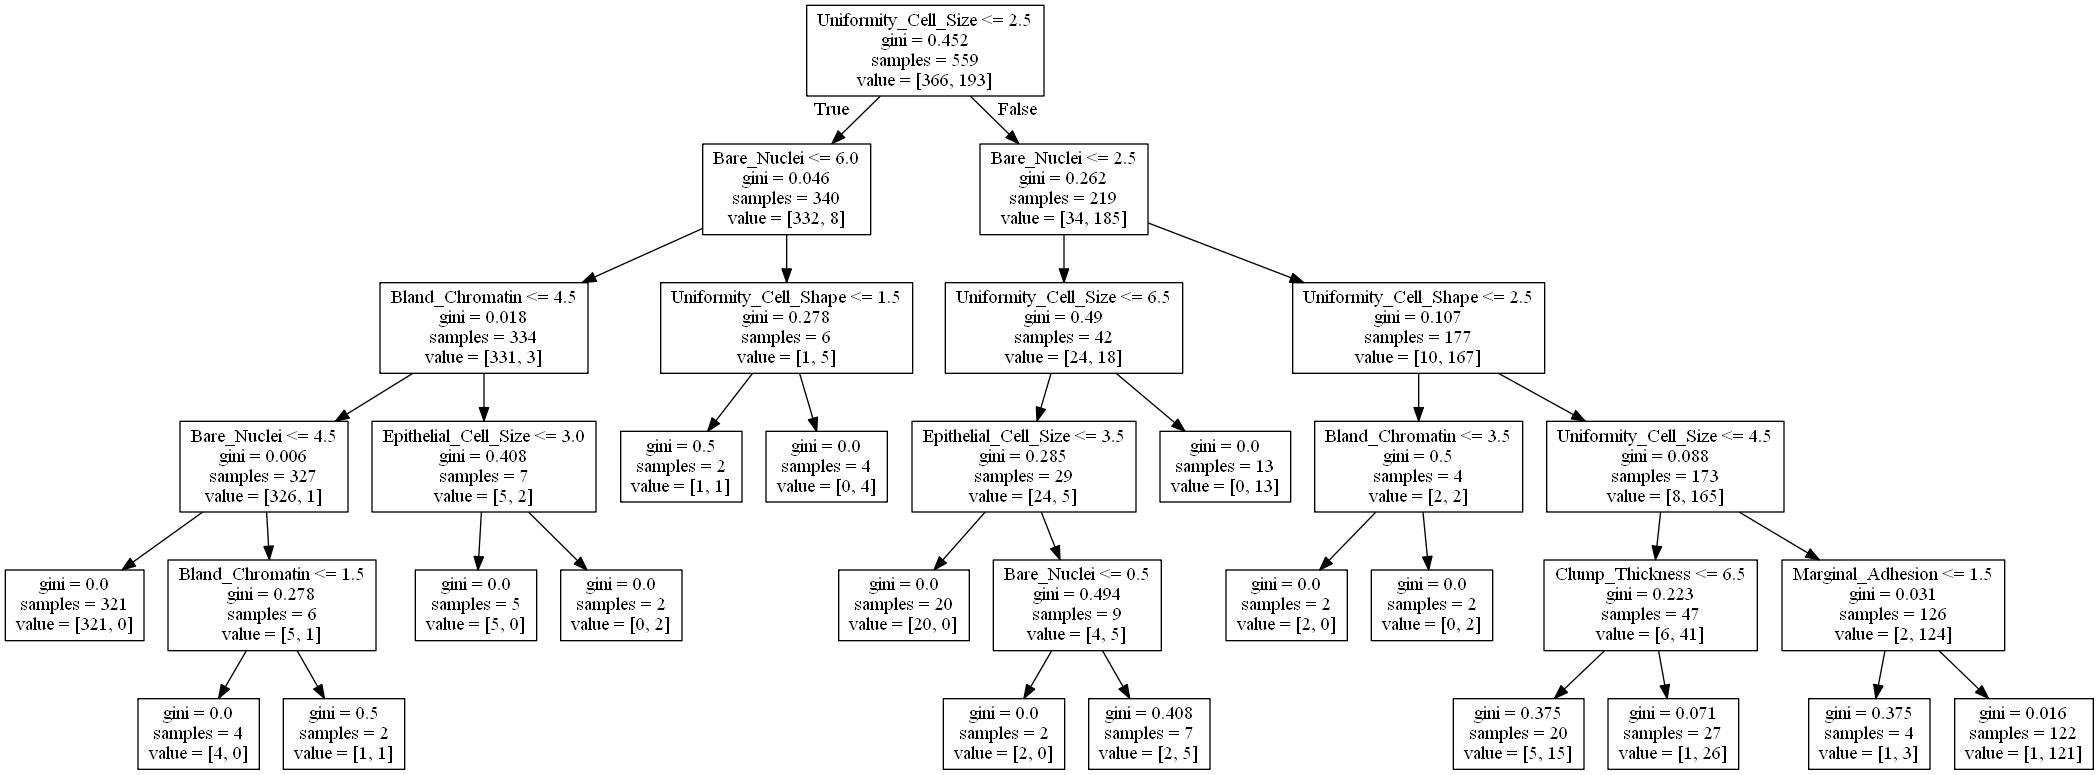

In [33]:
# establish the PNG image file type of the decision tree results
file_out = 'model_gini'
tree_visualize(model_gini, col_names, file_out)
# display the image
Image(filename=file_out+'.png')

### The AUC Score

In [34]:
# return the classifications of the binary states of the fitted models
print('         Benign-Malignant')
print('entropy: {}'.format(model_ent.classes_))
print('gini:    {}'.format(model_gini.classes_))

         Benign-Malignant
entropy: [0 1]
gini:    [0 1]


In [35]:
# predict the probabilities for each decision tree
y_ent_pred_proba = model_ent.predict_proba(X_test)
y_gini_pred_proba = model_gini.predict_proba(X_test)

print('ENTROPY MODEL PROBABILITIES')
print(y_ent_pred_proba[0:21,:])
print('\nGINI MODEL PROBABILITIES')
print(y_gini_pred_proba[0:21,:])

ENTROPY MODEL PROBABILITIES
[[1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.25       0.75      ]
 [1.         0.        ]
 [0.78571429 0.21428571]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]]

GINI MODEL PROBABILITIES
[[1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.00819672 0.99180328]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.00819672 0.99180328]
 [0.28571429 0.71428571]
 [1.         0.        ]
 [1.         0.        ]
 [0.03703704 0.96296296]
 [0.00819672 0.99180328]
 [1.         0.     

In [36]:
# compute the AUC scores
print('AUC Scores - Malignant')
print('entropy: {}'.format(roc_auc_score(y_test, y_ent_pred_proba[:,1])))
print('gini:    {}'.format(roc_auc_score(y_test, y_gini_pred_proba[:,1])))

AUC Scores - Malignant
entropy: 0.9690896739130436
gini:    0.9346693840579711


### Precision and Recall

In [37]:
# return the precision and recall results
print('ENTROPY MODEL')
print(classification_report(y_test, y_ent_pred))
print('\nGINI MODEL')
print(classification_report(y_test, y_gini_pred))

ENTROPY MODEL
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        92
           1       0.95      0.85      0.90        48

    accuracy                           0.94       140
   macro avg       0.94      0.92      0.93       140
weighted avg       0.94      0.94      0.93       140


GINI MODEL
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        92
           1       0.91      0.90      0.91        48

    accuracy                           0.94       140
   macro avg       0.93      0.93      0.93       140
weighted avg       0.94      0.94      0.94       140



## Questions to Respond  

1. Test both entropy and the gini coefficient. Which performs better and why?
  - For the basic decision tree models, the Entropy and Gini models, the best accuracy results are:  
         - Entropy: 93.57%  
         - Gini:    90.00%
  - Thus, the baseline accuracy shows that the entropy model performs best.  
  - The better performance could reasonably be from the improved balance of the split function calls acted upon by the entropy algorithm.

2. What are the best hyperparameter settings for both models with respect to accuracy?  
  - For the hyperparameter tuning, 4 values were modified, with the resultant optimizations:
         - MAX LEAF NODES | entropy = 3 for 93.57% accuracy.
           MAX LEAF NODES | gini    = 3 for 92.14% accuracy.  
           
         - MAX TREE DEPTH | entropy = 8 for 93.57% accuracy.
           MAX TREE DEPTH | gini    = 7 for 92.85% accuracy.
           
         - MAX SAMPLES LEAF | entropy = 5 for 94.29% accuracy.
           MAX SAMPLES LEAF | gini    = 5 for 92.14% accuracy.
           
         - MAX SAMPLES SPLIT | entropy = 7 for 94.29% accuracy.
           MAX SAMPLES SPLIT | gini    = 7 for 92.14% accuracy.  
  - As these results show, the entropy model reflects higher accuracies overall, as previsouly stated above.  
  - So as to proceed with the highest accuracy hyperparameters, the following were selected to build the final model results:
         - MAX LEAF NODES = None
         - MAX TREE DEPTH = 5
         - MAX SAMPLES LEAF = 2
         - MAX SAMPLES SPLIT = 3
         
         - These each gave  93.57% (entropy) and 92.86% (gini) accuracies.

3. Visualize both models and see which feature is selected for each criterion. Are they same for both? Why or why not?
  - No, the 2 decision trees do not return the same node labels for each criterion. This is easily seen upon inspection of the graphical tree outputs as shown above.
  - The 2 visualizations are based on similar but different algorithms, that primarily explains why the results are not identical. In general, an entropy model will result in a better 'balanced' tree as apposed to the gini model. However, the graphs shown above appear to show in contradiction to this perspective. Ultimately, the rewsultant splits occur in differnt places due to the different algorithms applied.

4. Determine the AUC for the best model you can achieve. What are the precision and recall values and which might be the one you want to maximize?
  - The AUC scores for each (malignant) decision tree prediction are:  
         - entropy: 0.9690896739130436
         - gini:    0.9543704710144927
  - The precision and recall values resultant from the decision tree models are:  
         ENTROPY          precision  recall
         - 0 (benign)       0.93      0.98
           1 (malignant)    0.95      0.85
           
         GINI             precision  recall
         - 0 (benign)       0.95      0.97
           1 (malignant)    0.93      0.90

5. What are the implications of using this type of machine learning algorithm for breast cancer analysis?  
  - The implications of using a decision tree for health care and related exams is monumental.
  - A decision tree is relatively easy to employ and can be pruned in various ways in order to optimize results.
  - Furthermore, a decision tree is easliy interpretable and permits increased confidence in its conclusions. As a result, the effected individual and also the caring physician are both more likely to make good decisions regarding future outcomes based upon such models. 